In [1]:
import numpy as np
import random
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


In [2]:
def first_order_2_dim_ODE(X, t, a,b,c,d,e,f,a1,b1,c1,d1,e1,f1):
  x, y = X
  dx_dt = a+b*x+c*y+d*x*y+e*x**2+f*y**2
  dy_dt = a1+b1*x+c1*y+d1*x*y+e1*x*2+f1*y**2
  return dx_dt,dy_dt


In [3]:
import numpy as np
from scipy.integrate import odeint

def generate_and_solve_ode_samples_with_errors(first_order_2_dim_ODE, num_samples=10000, dt=0.01, num_steps=50, threshold=100, error_scale=0.05):
    # Time parameters
    t = np.linspace(0, num_steps * dt, num_steps)


    # Initialize lists to store parameters, initial conditions, and solutions
    params_list = []
    init_conditions_list = []
    solutions_list = []
    N_solutions_list = []
    d_solutions_list = []
    dN_solutions_list = []
    solutions_list_flatten = []
    N_solutions_list_flatten = []

    # Generate and solve for each sample
    for i in range(num_samples):
        while True:
            # Random parameters and initial conditions
            params = np.random.normal(0, 1, 12)  # Generate 12 random parameters using normal distribution of mean zero and std 1
            init_conditions = np.random.rand(2)  # Generate 2 random initial conditions between 0 and 1
            a, b, c, d, e, f, a1, b1, c1, d1, e1, f1 = params

            # Solve the ODE
            solution = odeint(first_order_2_dim_ODE, init_conditions, t, args=(a, b, c, d, e, f, a1, b1, c1, d1, e1, f1))
            x, y = solution.T

            # Check if the solution exceeds the threshold
            if np.max(x) <= threshold and np.min(x) >= -threshold and \
                np.max(y) <= threshold and np.min(y) >= -threshold:
                # Normalize x column
                x_min = x.min()
                x_max = x.max()
                x_normalized = (x - x_min) / (x_max - x_min)

                # Normalize y column
                y_min = y.min()
                y_max = y.max()
                y_normalized = (y - y_min) / (y_max - y_min)

                # Combine normalized x and y columns
                normalized_sample = np.column_stack((x_normalized, y_normalized))
                break

        # Store the original solution
        params_list.append(params)
        init_conditions_list.append(init_conditions)
        solutions_list.append(solution)
        N_solutions_list.append(normalized_sample.flatten('F'))
        d_solutions_list.append(np.gradient(solution, axis=0).flatten('F'))
        dN_solutions_list.append(np.gradient(normalized_sample, axis=0).flatten('F'))
        solutions_list_flatten.append(solution.flatten('F'))
        N_solutions_list_flatten.append(normalized_sample.flatten('F'))

        # Generate and store solutions with added errors
        k=random.randint(0, 10)
        for _ in range(k):
            error = np.random.normal(0, error_scale, solution.shape)
            solution_with_error = solution + error
            x_err, y_err = solution_with_error.T

            # Normalize x_err column
            x_err_min = x_err.min()
            x_err_max = x_err.max()
            x_err_normalized = (x_err - x_err_min) / (x_err_max - x_err_min)

            # Normalize y_err column
            y_err_min = y_err.min()
            y_err_max = y_err.max()
            y_err_normalized = (y_err - y_err_min) / (y_err_max - y_err_min)

            # Combine normalized x_err and y_err columns
            normalized_sample_err = np.column_stack((x_err_normalized, y_err_normalized))

            params_list.append(params)
            init_conditions_list.append(init_conditions)
            solutions_list.append(solution_with_error)
            N_solutions_list.append(normalized_sample_err.flatten('F'))
            d_solutions_list.append(np.gradient(solution_with_error, axis=0).flatten('F'))
            dN_solutions_list.append(np.gradient(normalized_sample_err, axis=0).flatten('F'))
            solutions_list_flatten.append(solution_with_error.flatten('F'))
            N_solutions_list_flatten.append(normalized_sample_err.flatten('F'))

    return {
        'params_list': params_list,
        'init_conditions_list': init_conditions_list,
        'solutions_list': solutions_list,
        'N_solutions_list': N_solutions_list,
        'd_solutions_list': d_solutions_list,
        'dN_solutions_list': dN_solutions_list,
        'solutions_list_flatten': solutions_list_flatten,
        'N_solutions_list_flatten': N_solutions_list_flatten
    }

# Usage example
# result = generate_and_solve_ode_samples_with_errors(first_order_2_dim_ODE, num_samples=5000, dt=0.01, num_steps=1000, threshold=100, error_scale=0.05)
# params_list = result['params_list']
# init_conditions_list = result['init_conditions_list']
# solutions_list = result['solutions_list']
# N_solutions_list = result['N_solutions_list']
# d_solutions_list = result['d_solutions_list']
# dN_solutions_list = result['dN_solutions_list']
# solutions_list_flatten = result['solutions_list_flatten']
# N_solutions_list_flatten = result['N_solutions_list_flatten']


In [4]:
Data=generate_and_solve_ode_samples_with_errors(first_order_2_dim_ODE)

<ipython-input-3-f5df9983c2a6>:27: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(first_order_2_dim_ODE, init_conditions, t, args=(a, b, c, d, e, f, a1, b1, c1, d1, e1, f1))


In [6]:
data_size = len(Data["N_solutions_list"])
indices = torch.randperm(data_size)

train_size = int(0.2 * data_size)
test_size = data_size - train_size

X_test, X_train = torch.split(torch.tensor(Data["N_solutions_list"])[indices], [train_size, test_size])
dX_test, dX_train = torch.split(torch.tensor(Data["dN_solutions_list"])[indices], [train_size, test_size])
y_test, y_train = torch.split(torch.tensor(Data["params_list"])[indices], [train_size, test_size])

<ipython-input-6-a957020d3314>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X_test, X_train = torch.split(torch.tensor(Data["N_solutions_list"])[indices], [train_size, test_size])


In [8]:
y_test.shape

torch.Size([12048, 12])

In [9]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [19]:
import copy
# Define the neural network
class Net(nn.Module):
      def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(100,1000)
        self.dropout = nn.Dropout(p=0.2) # Input layer to hidden layer
        self.fc2 = nn.Linear(1000, 300)
        self.dropout = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(300, 120)
        self.fc4 = nn.Linear(120, 12)
          # Hidden layer to output layer  # Simple linear layer

      def forward(self, x):
        x = F.elu(self.fc1(x))
        x=self.dropout(x)
        x=F.elu(self.fc2(x))
        x=self.dropout(x)
        x= F.elu(self.fc3(x))
        x=self.fc4(x)
        return x

net = Net()
net = net.to(dtype=torch.float64)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

# Train step function
def train_step(model, criterion, optimizer, x, y):
    model.train()
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def validation_step(model, criterion, x, y):
    model.eval()
    with torch.no_grad():
        output = model(x)
        loss = criterion(output, y)
    return loss.item()

# Training and evaluation loop with loss tracking
def train_and_evaluate(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = []
    val_losses = []
    best_te_loss = float('inf')
    best_model = None
    for epoch in range(epochs):
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            train_loss += train_step(model, criterion, optimizer, x_batch, y_batch)
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        for x_batch, y_batch in test_loader:
            val_loss += validation_step(model, criterion, x_batch, y_batch)
        val_loss /= len(test_loader)
        val_losses.append(val_loss)

        # Save the model state if the current training loss is lower than the best training loss recorded
        if val_loss < best_te_loss:
            best_te_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())

        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{epochs}] Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    return train_losses, val_losses,best_t_loss,best_model_state

# Run the training and evaluation
train_losses, val_losses,best_t_loss,best_model_state = train_and_evaluate(net, criterion, optimizer, train_loader, test_loader, epochs=250)



Epoch [0/250] Train Loss: 0.8683, Validation Loss: 0.8410
Epoch [10/250] Train Loss: 0.7786, Validation Loss: 0.7761
Epoch [20/250] Train Loss: 0.7639, Validation Loss: 0.7633
Epoch [30/250] Train Loss: 0.7546, Validation Loss: 0.7543
Epoch [40/250] Train Loss: 0.7474, Validation Loss: 0.7474
Epoch [50/250] Train Loss: 0.7418, Validation Loss: 0.7429
Epoch [60/250] Train Loss: 0.7375, Validation Loss: 0.7392
Epoch [70/250] Train Loss: 0.7326, Validation Loss: 0.7363
Epoch [80/250] Train Loss: 0.7298, Validation Loss: 0.7331
Epoch [90/250] Train Loss: 0.7270, Validation Loss: 0.7311
Epoch [100/250] Train Loss: 0.7248, Validation Loss: 0.7307
Epoch [110/250] Train Loss: 0.7225, Validation Loss: 0.7283
Epoch [120/250] Train Loss: 0.7199, Validation Loss: 0.7281
Epoch [130/250] Train Loss: 0.7184, Validation Loss: 0.7274
Epoch [140/250] Train Loss: 0.7165, Validation Loss: 0.7265
Epoch [150/250] Train Loss: 0.7143, Validation Loss: 0.7257
Epoch [160/250] Train Loss: 0.7132, Validation Loss

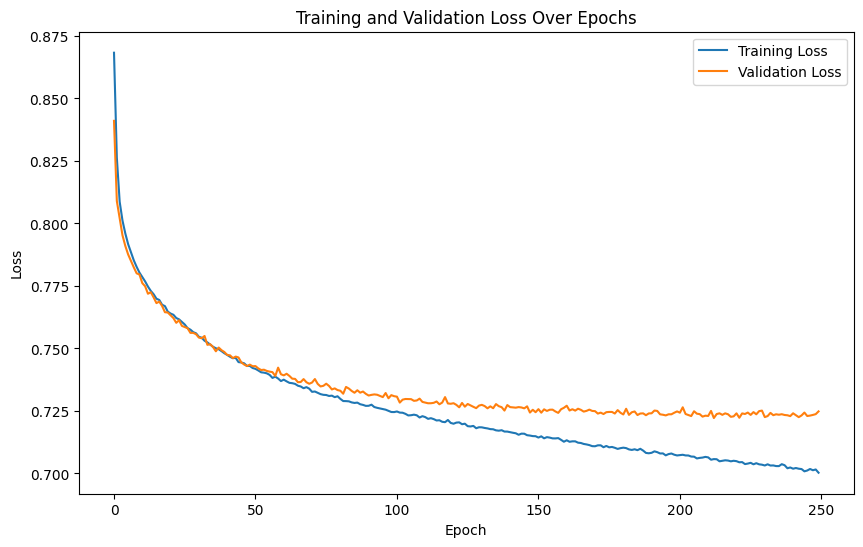

In [20]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [26]:
type(best_model_state)

collections.OrderedDict

In [29]:
import pickle
# Save the OrderedDict to a file
with open('model_state.pkl', 'wb') as file:
    pickle.dump(best_model_state, file)

In [31]:
# Load the state_dict from the file
with open('/kaggle/working/model_state.pkl', 'rb') as file:
    x = pickle.load(file)

In [70]:
y_pred=net(X_test[0]).tolist()
y_tar=y_test[0].tolist()

In [72]:
y_pred

[-0.412159984640298,
 -0.0985671783643202,
 0.6600755771474839,
 0.17507878353518483,
 -0.11450312734241673,
 0.28856552891813286,
 -0.4968148898295924,
 -0.03830962656013697,
 -0.19371599514274296,
 -0.1198787397600529,
 -0.09714633965064007,
 -0.24793741011843046]

In [76]:
y_tar[11]

0.36588531544029546

In [80]:
t = np.linspace(0, 50 * 0.01, 50)
solution_pred = odeint(first_order_2_dim_ODE, [0,0], t, args=(y_pred[0],y_pred[1],y_pred[2],y_pred[3],y_pred[4],y_pred[5],y_pred[6],y_pred[7],y_pred[8],y_pred[9],y_pred[10],y_pred[11]))
x_pred1,y_pred1=solution_pred.T

In [84]:
solution_tar = odeint(first_order_2_dim_ODE, [0,0], t, args=(y_tar[0],y_tar[1],y_tar[2],y_tar[3],y_tar[4],y_tar[5],y_tar[6],y_tar[7],y_tar[8],y_tar[9],y_tar[10],y_tar[11]))
x_tar1,y_tar1=solution_tar.T

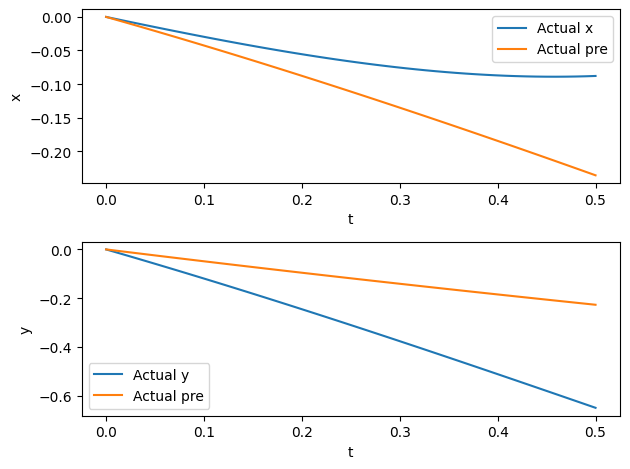

In [90]:

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax1.plot(t, x_tar1, label='Actual x')
ax1.plot(t, x_pred1, label='Actual pre')
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.legend() 

ax2 = fig.add_subplot(212)
ax2.plot(t, y_tar1, label='Actual y')
ax2.plot(t, y_pred1, label='Actual pre')
ax2.set_xlabel('t')
ax2.set_ylabel('y')

plt.tight_layout()
ax2.legend() 
plt.show()